In [1]:
from requests import get
from bs4 import BeautifulSoup
from warnings import warn
from time import sleep
from random import randint
import numpy as np, pandas as pd
import seaborn as sns

In [2]:
pages = np.arange(1, 9951, 50)
headers = {'Accept-Language': 'en-US,en;q=0.8'}

In [3]:
titles = []
years = []
ratings = []
genres = []
runtimes = []
imdb_ratings = []
imdb_ratings_standardized = []
metascores = []
votes = []

In [5]:
for page in pages:
  
   #get request for sci-fi
   response = get("https://www.imdb.com/search/title?genres=sci-fi&"
                  + "start="
                  + str(page)
                  + "&explore=title_type,genres&ref_=adv_prv", headers=headers)
  
   sleep(randint(8,15))
   
   #throw warning for status codes that are not 200
   if response.status_code != 200:
       warn('Request: {}; Status code: {}'.format(requests, response.status_code))

   #parse the content of current iteration of request
   page_html = BeautifulSoup(response.text, 'html.parser')
      
   movie_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')
  
   #extract the 50 movies for that page
   for container in movie_containers:

       #conditional for all with metascore
       if container.find('div', class_ = 'ratings-metascore') is not None:

           #title
           title = container.h3.a.text
           titles.append(title)

           if container.h3.find('span', class_= 'lister-item-year text-muted unbold') is not None:
            
             #year released
             year = container.h3.find('span', class_= 'lister-item-year text-muted unbold').text # remove the parentheses around the year and make it an integer
             years.append(year)

           else:
             years.append(None) # each of the additional if clauses are to handle type None data, replacing it with an empty string so the arrays are of the same length at the end of the scraping

           if container.p.find('span', class_ = 'certificate') is not None:
            
             #rating
             rating = container.p.find('span', class_= 'certificate').text
             ratings.append(rating)

           else:
             ratings.append("")

           if container.p.find('span', class_ = 'genre') is not None:
            
             #genre
             genre = container.p.find('span', class_ = 'genre').text.replace("\n", "").rstrip().split(',') # remove the whitespace character, strip, and split to create an array of genres
             genres.append(genre)
          
           else:
             genres.append("")

           if container.p.find('span', class_ = 'runtime') is not None:

             #runtime
             time = int(container.p.find('span', class_ = 'runtime').text.replace(" min", "")) # remove the minute word from the runtime and make it an integer
             runtimes.append(time)

           else:
             runtimes.append(None)

           if float(container.strong.text) is not None:

             #IMDB ratings
             imdb = float(container.strong.text) # non-standardized variable
             imdb_ratings.append(imdb)

           else:
             imdb_ratings.append(None)

           if container.find('span', class_ = 'metascore').text is not None:

             #Metascore
             m_score = int(container.find('span', class_ = 'metascore').text) # make it an integer
             metascores.append(m_score)

           else:
             metascores.append(None)

           if container.find('span', attrs = {'name':'nv'})['data-value'] is not None:

             #Number of votes
             vote = int(container.find('span', attrs = {'name':'nv'})['data-value'])
             votes.append(vote)

           else:
               votes.append(None)


In [6]:
sci_fi_df = pd.DataFrame({'movie': titles,
                      'year': years,
                      'rating': ratings,
                      'genre': genres,
                      'runtime_min': runtimes,
                      'imdb': imdb_ratings,
                      'metascore': metascores,
                      'votes': votes}
                      )

sci_fi_df.loc[:, 'year'] = sci_fi_df['year'].str[-5:-1] # two more data transformations after scraping
# Drop 'ovie' bug
# Make year an int
sci_fi_df['n_imdb'] = sci_fi_df['imdb'] * 10
final_df = sci_fi_df.loc[sci_fi_df['year'] != 'ovie'] # One small issue with the scrape on these two movies so just dropping those ones.
final_df.loc[:, 'year'] = pd.to_numeric(final_df['year'])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [7]:
final_df.head()

,movie,year,rating,genre,runtime_min,imdb,metascore,votes,n_imdb
0,Black Panther: Wakanda Forever,2022,PG-13,"[Action, Adventure, Drama]",161,7.3,67,105762,73.0
1,Black Adam,2022,PG-13,"[Action, Adventure, Fantasy]",125,6.7,41,148932,67.0
2,Strange World,2022,PG,"[Animation, Action, Adventure]",102,4.7,65,7431,47.0
3,Nope,2022,R,"[Horror, Mystery, Sci-Fi]",130,6.9,77,165993,69.0
4,Everything Everywhere All at Once,2022,R,"[Action, Adventure, Comedy]",139,8.1,81,244476,81.0


In [8]:
final_df.describe()

,year,runtime_min,imdb,metascore,votes,n_imdb
count,1342.000000,1342.000000,1342.000000,1342.000000,1.342000e+03,1342.000000
mean,2004.569300,105.011177,6.107824,52.929955,1.356004e+05,61.078241
std,15.690354,18.528106,1.069804,17.023461,2.312317e+05,10.698038
min,1927.000000,60.000000,1.500000,6.000000,8.100000e+01,15.000000
25%,1997.000000,92.000000,5.500000,41.000000,1.005450e+04,55.000000
50%,2009.500000,101.000000,6.200000,53.000000,4.069300e+04,62.000000
75%,2017.000000,114.000000,6.800000,65.000000,1.489292e+05,68.000000
max,2022.000000,242.000000,8.800000,98.000000,2.339480e+06,88.000000


In [9]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1342 entries, 0 to 1343
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        1342 non-null   object 
 1   year         1342 non-null   int64  
 2   rating       1342 non-null   object 
 3   genre        1342 non-null   object 
 4   runtime_min  1342 non-null   int64  
 5   imdb         1342 non-null   float64
 6   metascore    1342 non-null   int64  
 7   votes        1342 non-null   int64  
 8   n_imdb       1342 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 104.8+ KB


In [12]:
import matplotlib.pyplot as plt

[]

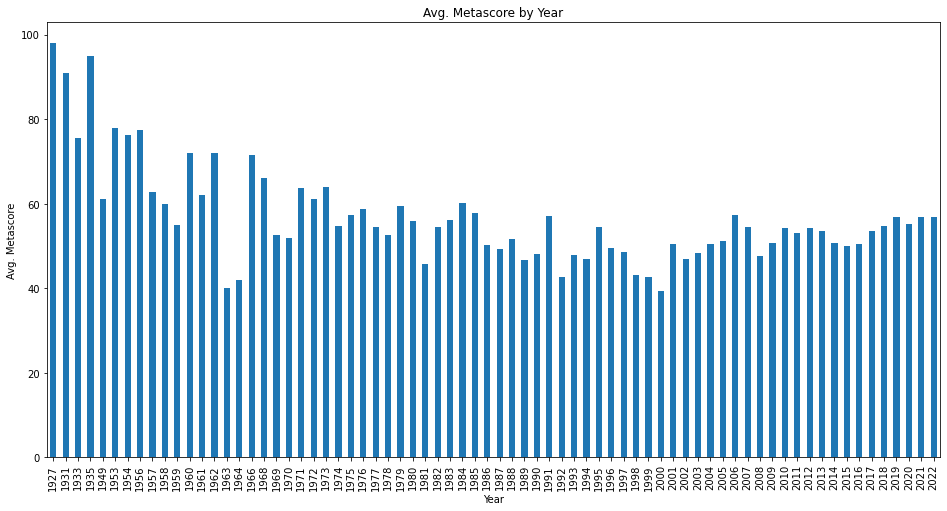

In [13]:
# What are the average metascores by year?
final_df.groupby('year')['metascore'].mean().plot(kind='bar', figsize=(16,8), title="Avg. Metascore by Year", xlabel="Year", ylabel="Avg. Metascore")
plt.xticks(rotation=90)
plt.plot()

<AxesSubplot:>

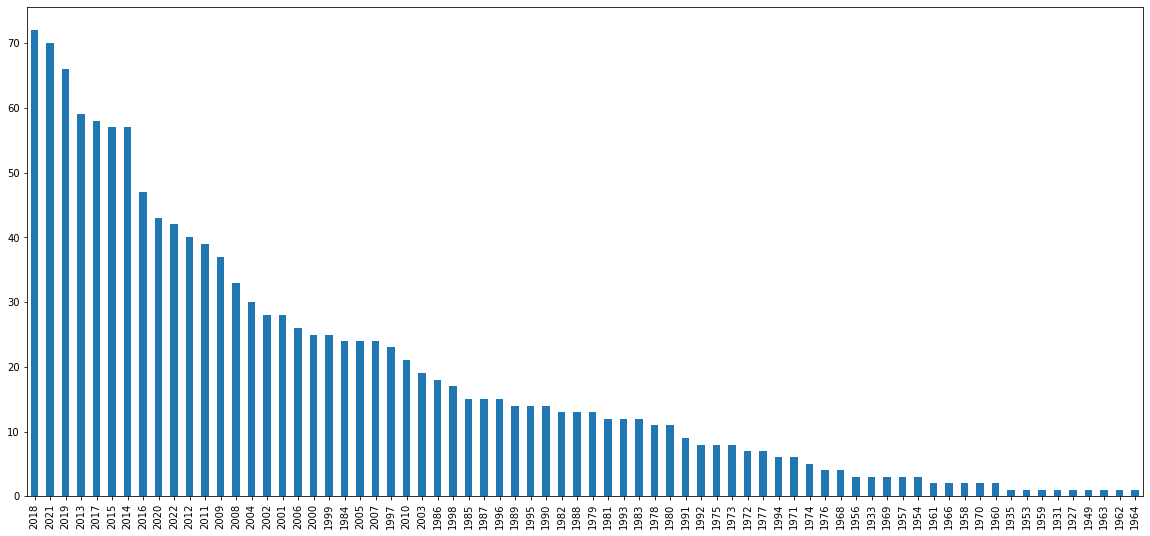

In [14]:
#Number of Movies by Year
final_df['year'].value_counts().plot(kind='bar', figsize=[20,9])

In [17]:
final_df.to_csv('SCI_FI_MOVIES_FROM_IMDB.csv', index=False)